In [32]:
import torch
import pandas as pd
import numpy as np
from transformers import PatchTSTConfig, PatchTSTForPrediction
import os

path = os.getcwd()

file_path = os.path.join(path, 'Native_Load_2024.xlsx') 

# Load and preprocess ERCOT data
def load_ercot_data(file_path):
    df = pd.read_excel(file_path, sheet_name='Sheet1')  # Load from Excel
    df['Hour Ending'] = df['Hour Ending'].str.replace(' 24:00', ' 00:00')
    df['Hour Ending'] = pd.to_datetime(df['Hour Ending'].str.split().str[0] + ' ' + df['Hour Ending'].str.split().str[1], format='%m/%d/%Y %H:%M', errors='coerce') + pd.Timedelta(days=1)
    df.dropna(subset=['Hour Ending'], inplace=True)
    df.set_index('Hour Ending', inplace=True)
    return df

# Aggregate hourly data to daily data
def aggregate_to_daily(data):
    # Sum COAST, EAST, FWEST, NORTH, NCENT, SOUTH, SCENT, WEST
    area_sums = data[['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST']].resample('D').sum()
    # Sum ERCOT
    ercot_sum = data['ERCOT'].resample('D').sum()
    # Concatenate the new daily columns
    daily_data = pd.concat([area_sums, ercot_sum], axis=1)
    return daily_data

# Normalize the data
def normalize_data(data):
    return (data - data.mean()) / data.std()

# Prepare data for PatchTST
def prepare_data(data, context_length, prediction_length):
    X = []
    for i in range(len(data) - context_length - prediction_length + 1):
        X.append(data[i:i+context_length].values)
    return np.array(X)

# Load and preprocess ERCOT data
ercot_data = load_ercot_data('Native_Load_2024.xlsx')
daily_ercot_data = aggregate_to_daily(ercot_data)  # Aggregate to daily data
normalized_data = normalize_data(daily_ercot_data)  # Normalize daily data

# Set parameters
context_length = 276  # Use 276 days of historical data
prediction_length = 30  # Forecast 90 days into the future
num_input_channels = normalized_data.shape[1]

# Ensure there is enough data to generate sequences
if len(normalized_data) < context_length + prediction_length:
    raise ValueError("Not enough data to generate sequences with the given context_length and prediction_length.")

# Prepare input data
X = prepare_data(normalized_data, context_length, prediction_length)
X = torch.tensor(X, dtype=torch.float32)

if X.size(0) == 0:
    raise ValueError("The prepared data tensor X is empty. Please check the input data and parameters.")

# Configure and initialize PatchTST model
config = PatchTSTConfig(
    num_input_channels=num_input_channels,
    prediction_length=prediction_length,
    context_length=context_length,
    patch_length=16,
    patch_stride=8,
    num_hidden_layers=4,
    d_model=128,
    num_attention_heads=4,
    ffn_dim=256,
    norm_type='layernorm',
    positional_encoding_type='sincos'
)

model = PatchTSTForPrediction(config)

# Perform prediction
with torch.no_grad():
    output = model(past_values=X[-1].unsqueeze(0))

# Denormalize the predictions
predictions = output.prediction_outputs.squeeze().numpy()
predictions = predictions * normalized_data.std().values + normalized_data.mean().values

# Create a date range for the forecast
last_date = daily_ercot_data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_length)

# Create a DataFrame with the forecasted values
forecast_df = pd.DataFrame(predictions, index=forecast_dates, columns=daily_ercot_data.columns)

print("Forecast for the next 90 days:")
print(forecast_df)


Forecast for the next 90 days:
               COAST      EAST     FWEST     NORTH     NCENT     SOUTH  \
2025-01-02  0.238694  0.027619  0.066691  0.088030  0.069325  0.304030   
2025-01-03  0.250483  0.043813  0.081094  0.105182  0.084813  0.309716   
2025-01-04  0.263325  0.056764  0.088614  0.117719  0.099038  0.321709   
2025-01-05  0.255013  0.050148  0.083571  0.109743  0.090339  0.315738   
2025-01-06  0.283940  0.078914  0.103390  0.139951  0.121447  0.340152   
2025-01-07  0.251628  0.047795  0.082580  0.110295  0.089623  0.309340   
2025-01-08  0.280736  0.076036  0.102481  0.136443  0.117188  0.336635   
2025-01-09  0.239813  0.034587  0.071576  0.093554  0.073558  0.301502   
2025-01-10  0.254161  0.049602  0.082960  0.111539  0.091751  0.312381   
2025-01-11  0.294675  0.089526  0.113334  0.152630  0.133251  0.349941   
2025-01-12  0.263334  0.058470  0.088270  0.119947  0.100639  0.321410   
2025-01-13  0.299649  0.092165  0.112298  0.154645  0.136422  0.355741   
2025-01

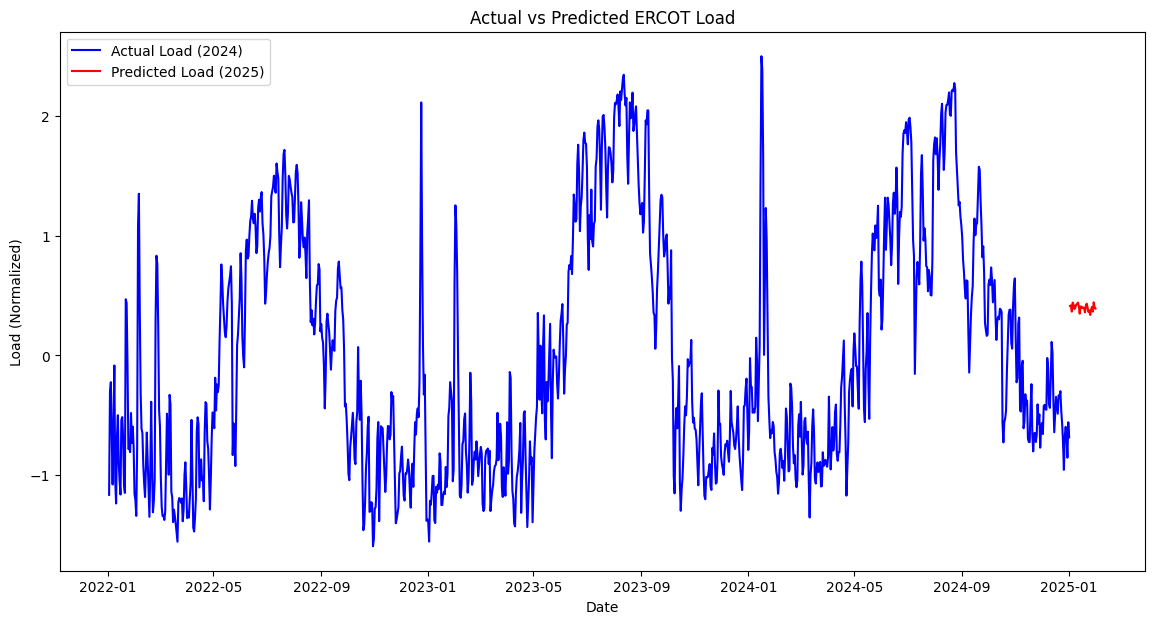

In [37]:
import matplotlib.pyplot as plt

# Plot the actual and predicted loads
plt.figure(figsize=(14, 7))

# Plot the actual loads from the native load 2024 file
plt.plot(normalized_data.index, normalized_data['ERCOT'], label='Actual Load (2024)', color='blue')

# Plot the predicted loads
plt.plot(forecast_dates, forecast_df['ERCOT'], label='Predicted Load (2025)', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Load (Normalized)')
plt.title('Actual vs Predicted ERCOT Load')
plt.legend()

# Show the plot
plt.show()

In [38]:
path = os.getcwd()
# Load and preprocess data
df2 = pd.read_excel(path + "/Native_Load_2025.xlsx")

# Drop na rows
df2.dropna(inplace=True)

# Clean and convert datetime
df2['Hour Ending'] = (df2['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df2['Hour Ending'] = pd.to_datetime(df2['Hour Ending'], format='%m/%d/%Y %H:%M')
df2.set_index('Hour Ending', inplace=True)
load_series = df2['ERCOT'].astype(float)

# Feature engineering
df2['hour'] = df2.index.hour
df2['dayofweek'] = df2.index.dayofweek
df2['dayofyear'] = df2.index.dayofyear


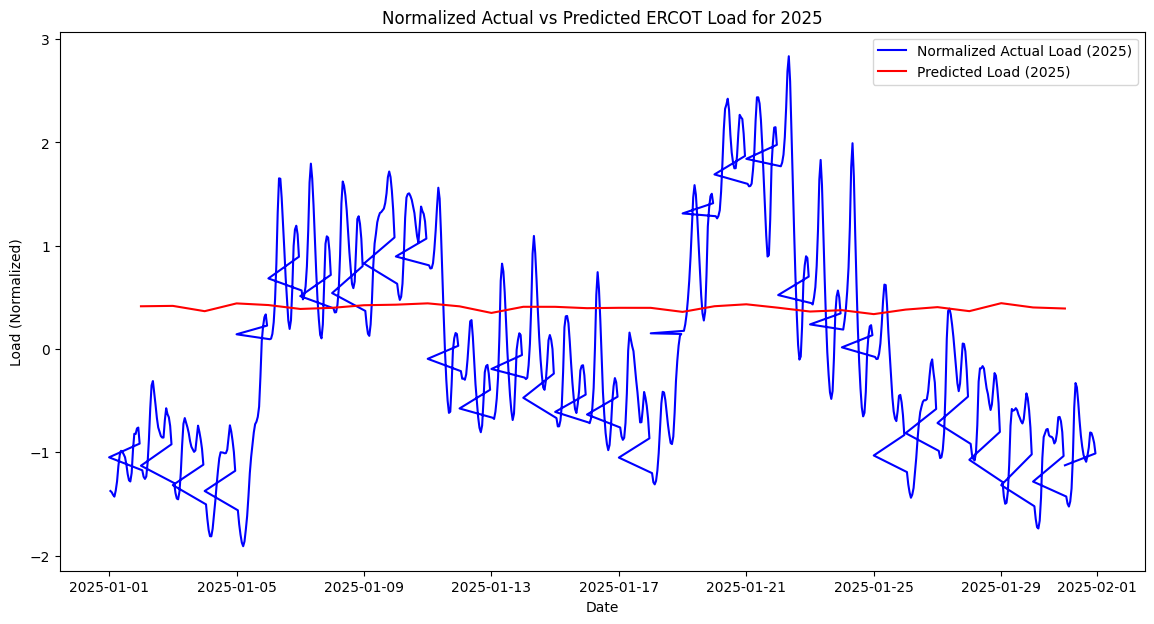

In [39]:
# Normalize the actual load (2025) dataset
normalized_actual_load_2025 = normalize_data(df2[['ERCOT']])

# Plot the actual and predicted loads
plt.figure(figsize=(14, 7))

# Plot the normalized actual loads from the 2025 dataset
plt.plot(normalized_actual_load_2025.index, normalized_actual_load_2025['ERCOT'], label='Normalized Actual Load (2025)', color='blue')

# Plot the predicted loads
plt.plot(forecast_dates, forecast_df['ERCOT'], label='Predicted Load (2025)', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Load (Normalized)')
plt.title('Normalized Actual vs Predicted ERCOT Load for 2025')
plt.legend()

# Show the plot
plt.show()